In [1]:
import os
import numpy as np
import dill
import torch
import lovely_tensors as lt
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict
from datetime import datetime
lt.monkey_patch()

import csng
from csng.utils.comparison import plot_reconstructions
from csng.utils.data import standardize, normalize

### set paths
DATA_PATH = os.environ["DATA_PATH"]
DATA_PATH_CAT_V1 = os.path.join(DATA_PATH, "cat_V1_spiking_model", "50K_single_trial_dataset")
DATA_PATH_MOUSE_V1 = os.path.join(DATA_PATH, "mouse_v1_sensorium22")
DATA_PATH_BRAINREADER = os.path.join(DATA_PATH, "brainreader")

### Load

In [17]:
to_load = [
    # "results/channels_seed0/2024-12-15_13-28-09.pt",
    # "results/channels_seed1/2024-12-15_13-12-02.pt",
    # "results/channels_seed2/2024-12-15_13-01-44.pt",

    "results/n_batches/2024-12-13_21-08-23.pt"

    # "results/n_neurons/2024-12-15_17-19-41.pt",

    # "results/resp_transform_and_coords_seed0/2024-12-15_17-26-34.pt",
    # "results/resp_transform_and_coords_seed1/2024-12-15_17-27-34.pt",
    # "results/resp_transform_and_coords_seed2/2024-12-15_17-29-16.pt",

    # "results/training_loss/2024-12-13_20-59-35.pt",
    # "results/training_loss_seed1/2024-12-15_17-14-10.pt",
    # "results/training_loss_seed2/2024-12-15_17-16-07.pt",

    # "results/b_all/2024-12-13_21-41-25.pt",
    
    # "results/syn_data_last_ep/2024-12-13_21-28-10.pt"
]

runs, runs_cfg = {}, {}
for path in to_load:
    runs_ckpt = torch.load(path, pickle_module=dill)
    _runs, _runs_cfg = runs_ckpt["runs"], runs_ckpt["config"]
    for run_name, run_dict in _runs.items():
        if run_name in runs:
            i = 2
            while f"{run_name}_{i}" in runs: i += 1 
            run_name = f"{run_name}_{i}"
        runs[run_name] = run_dict
        _runs_cfg[run_name] = _runs_cfg

print("Loaded runs:")
for method_name, results in runs.items():
    print(f"  {method_name}: {list(results.keys())}")

Loaded runs:
  GAN (100%): ['run_name', 'ckpt_path', 'test_losses', 'configs', 'histories', 'best_val_losses', 'stim_pred_best', 'ckpt_paths']
  GAN (75%): ['run_name', 'ckpt_path', 'test_losses', 'configs', 'histories', 'best_val_losses', 'stim_pred_best', 'ckpt_paths']
  GAN (50%): ['run_name', 'ckpt_path', 'test_losses', 'configs', 'histories', 'best_val_losses', 'stim_pred_best', 'ckpt_paths']
  GAN (25%): ['run_name', 'ckpt_path', 'test_losses', 'configs', 'histories', 'best_val_losses', 'stim_pred_best', 'ckpt_paths']
  GAN (10%): ['run_name', 'ckpt_path', 'test_losses', 'configs', 'histories', 'best_val_losses', 'stim_pred_best', 'ckpt_paths']
  GAN (5%): ['run_name', 'ckpt_path', 'test_losses', 'configs', 'histories', 'best_val_losses', 'stim_pred_best', 'ckpt_paths']
  GAN (2.5%): ['run_name', 'ckpt_path', 'test_losses', 'configs', 'histories', 'best_val_losses', 'stim_pred_best', 'ckpt_paths']
  GAN (1%): ['run_name', 'ckpt_path', 'test_losses', 'configs', 'histories', 'best_

## Plot losses

In [18]:
### plotting config
to_plot = {
    ### amount of data
    "GAN (100%)": {"x": 4500},
    "GAN (75%)": {"x": int(0.75*4500)},
    "GAN (50%)": {"x": int(0.5*4500)},
    "GAN (25%)": {"x": int(0.25*4500)},
    "GAN (10%)": {"x": int(0.1*4500)},
    "GAN (5%)": {"x": int(0.05*4500)},
    "GAN (2.5%)": {"x": int(0.025*4500)},
    "GAN (1%)": {"x": int(0.01*4500)},

    ### neurons
    # "GAN (100%)": {"x": 8587},
    # "GAN (87.5%)": {"x": 7513},
    # "GAN (75%)": {"x": 6440},
    # "GAN (62.5%)": {"x": 5366},
    # "GAN (50%)": {"x": 4293},
    # "GAN (37.5%)": {"x": 3220},
    # "GAN (25%)": {"x": 2146},
    # "GAN (10%)": {"x": 858},
    # "GAN (5%)": {"x": 429},

    ### channels
    # "GAN (64)": {"x": 64, "label": "64", "other_seeds": ["GAN (64)_2", "GAN (64)_3"]},
    # "GAN (256)": {"x": 256, "label": "256", "other_seeds": ["GAN (256)_2", "GAN (256)_3"]},
    # "GAN (480)": {"x": 480, "label": "480", "other_seeds": ["GAN (480)_2", "GAN (480)_3"]},
    # "GAN (624)": {"x": 624, "label": "624", "other_seeds": ["GAN (624)_2", "GAN (624)_3"]},
    # "GAN (864)": {"x": 864, "label": "864", "other_seeds": ["GAN (864)_2", "GAN (864)_3"]},
    # "GAN (1028)": {"x": 1028, "label": "1028", "other_seeds": ["GAN (1028)_2", "GAN (1028)_3"]},
    # "GAN (1256)": {"x": 1256, "label": "1256", "other_seeds": ["GAN (1256)_2", "GAN (1256)_3"]},

    ### neuronal coordinates and response transformation
    # "GAN": {"x": "Base", "label": "Base", "other_seeds": ["GAN_2", "GAN_3"]},
    # "GAN (w/ C)": {"x": "w/ NC", "label": "w/ NC", "other_seeds": ["GAN (w/ C)_2", "GAN (w/ C)_3"]},
    # "GAN (w/ T)": {"x": "w/ T", "label": "w/ T", "other_seeds": ["GAN (w/ T)_2", "GAN (w/ T)_3"]},
    # "GAN (w/ C & T)": {"x": "w/ T + NC", "label": "w/ T + NC", "other_seeds": ["GAN (w/ C & T)_2", "GAN (w/ C & T)_3"]},
    
    ### training loss
    # "GAN (SSIML)": {"x": "SSIML", "label": "SSIML", "other_seeds": ["GAN (SSIML)_2", "GAN (SSIML)_3"]},
    # "GAN (MAE)": {"x": "MAE", "label": "MAE", "other_seeds": ["GAN (MAE)_2", "GAN (MAE)_3"]},
    # "GAN (MSE)": {"x": "MSE", "label": "MSE", "other_seeds": ["GAN (MSE)_2", "GAN (MSE)_3"]},

    ### B-All
    # "GAN (B-All)": {"x": "B-All"},
    # r"GAN (B-All $\rightarrow$ B-6)": {"x": r"B-All $\rightarrow$ B-6"},
    # "GAN (50% B-All + 50% S-All)": {"x": "50% B-All + 50% S-All"},
    # r"GAN (50% B-All + 50% S-All $\rightarrow$ B-6)": {"x": r"50% B-All + 50% S-All $\rightarrow$ B-6"},
}

In [19]:
### collect x and y values and reconstructions
xs, x_tick_labels, ys, ys_stds = [], [], defaultdict(list), defaultdict(list)
recons = []

for method_name, plot_info in to_plot.items():
    xs.append(plot_info["x"])
    x_tick_labels.append(plot_info.get("label", plot_info["x"]))
    for loss_name, loss in runs[method_name]["test_losses"][0]["total"].items():
        losses = [loss]
        if "other_seeds" in plot_info:
            for other_seed_run_name in plot_info["other_seeds"]:
                losses.append(runs[other_seed_run_name]["test_losses"][0]["total"][loss_name])
        ys[loss_name].append(np.mean(losses))
        ys_stds[loss_name].append(np.std(losses))

    ### validation loss
    ys["val_loss"].append(np.mean([runs[mname]["best_val_losses"][0] for mname in [method_name, *plot_info.get("other_seeds", [])]]))
    ys_stds["val_loss"].append(np.std([runs[mname]["best_val_losses"][0] for mname in [method_name, *plot_info.get("other_seeds", [])]]))

#### Line plot

In [20]:
plot_loss = "FID"
plot_loss_2 = "MSE"
x_label = "# of data points"
ticks_fontsize = 12
label_fontsize = 14

Saved to: results/__figures__/line_n_data_points.pdf


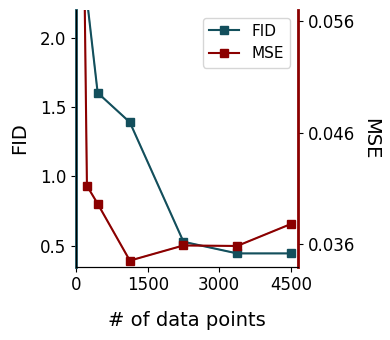

In [21]:
### line plot
to_plot_label = plot_loss
if plot_loss == "PL":
    to_plot_label = "Perceptual loss"

c1 = "#134f5cff"
c2 = "darkred"
# c = "tab:blue"

fig, ax = plt.subplots(ncols=1, figsize=(4, 3.5))
# fig, ax = plt.subplots(ncols=1, figsize=(6., 4))
ax.plot(xs, ys[plot_loss], marker="s", color=c1, label=plot_loss)
ax.fill_between(xs, np.array(ys[plot_loss]) - np.array(ys_stds[plot_loss]), np.array(ys[plot_loss]) + np.array(ys_stds[plot_loss]), color=c1, alpha=0.2)

### x axis
# ax.set_xlim(0, 8800)
# ax.set_xticks([0, 2500, 5000, 7500])
ax.set_xlim(0, 4650)
ax.set_xticks([0, 1500, 3000, 4500])
# ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=3, min_n_ticks=2))
ax.set_xticklabels(ax.get_xticks(), fontsize=ticks_fontsize)
ax.set_xlabel(x_label, labelpad=12, fontsize=label_fontsize)

### y axis
# ax.set_ylim(0.3-0.05, 0.75+0.05)
# ax.set_yticks([0.3, 0.45, 0.6, 0.75])
# ax.set_yticks([0.3, 0.6, 0.9])
ax.set_ylim(0.35, 2.2)
ax.set_yticks([0.5, 1, 1.5, 2])
# ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, min_n_ticks=2))
ax.set_yticklabels(ax.get_yticks(), fontsize=ticks_fontsize)
ax.set_ylabel(to_plot_label, labelpad=8, fontsize=label_fontsize)

### second y axis
if plot_loss_2 is not None:
    ax2 = ax.twinx()

    ax2.set_yticks([0.035, 0.038, 0.041])
    ax2.set_ylim([0.034, 0.057])
    # ax2.set_ylim([0.036, 0.057])
    ax2.set_yticks([0.036, 0.046, 0.056])
    ax2.spines["right"].set_color(c2)
    ax2.spines["right"].set_linewidth(2)
    ax2.spines["top"].set_visible(False)
    ax2.plot(xs, ys[plot_loss_2], marker="s", color=c2, label=plot_loss_2)
    ax2.fill_between(xs, np.array(ys[plot_loss_2]) - np.array(ys_stds[plot_loss_2]), np.array(ys[plot_loss_2]) + np.array(ys_stds[plot_loss_2]), color=c2, alpha=0.2)
    ax2.set_yticklabels(ax2.get_yticks(), fontsize=ticks_fontsize)
    ax2.set_ylabel(plot_loss_2, labelpad=18, fontsize=label_fontsize)
    ## rotate y label
    ax2.yaxis.label.set_rotation(270)

    ax.spines["left"].set_linewidth(2)
    ax.spines["left"].set_color(c1)

### add legend(s)
ax.legend(loc="upper left", fontsize=12)
# if plot_loss_2 is not None:
#     ax2.legend(loc="upper left", fontsize=12)
### combine legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc="upper right", fontsize=label_fontsize-3)


### general
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
os.makedirs("results/__figures__", exist_ok=True)
fig_name = f"results/__figures__/line_{x_label.lower().replace(' ', '-')}.pdf"
fig.savefig(fig_name, bbox_inches="tight")
print(f"Saved to: {fig_name}")

#### Bar plot

In [21]:
plot_loss = "FID"
plot_loss_2 = "MSE"
x_label = "Training data"
c1 = "#134f5cff"
c2 = "darkred"
ticks_fontsize = 12
label_fontsize = 14

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

to_plot_label = plot_loss
if plot_loss == "PL":
    to_plot_label = "Perceptual loss"

# fig, ax = plt.subplots(ncols=1, figsize=(6., 4.2))
fig, ax = plt.subplots(ncols=1, figsize=(6., 8.2))
# fig, ax = plt.subplots(ncols=1, figsize=(5, 5))

# Bar width and offsets
bar_width = 0.35
x_positions = np.arange(len(x_tick_labels))

# Plot first set of bars
ax.bar(x_positions - bar_width / 2, ys[plot_loss], bar_width, color=c1, label=to_plot_label)
# Add error bars for the first set
for i, (x, y) in enumerate(zip(x_positions, ys[plot_loss])):
    ax.errorbar(x - bar_width / 2, y, yerr=ys_stds[plot_loss][i], fmt="o", color="black", capsize=5)

# Create a secondary y-axis for the second set of bars
if plot_loss_2 is not None:
    ax2 = ax.twinx()
    ax2.bar(x_positions + bar_width / 2, ys[plot_loss_2], bar_width, color=c2, label=plot_loss_2)
    # Add error bars for the second set
    for i, (x, y) in enumerate(zip(x_positions, ys[plot_loss_2])):
        ax2.errorbar(x + bar_width / 2, y, yerr=ys_stds[plot_loss_2][i], fmt="o", color="black", capsize=5)

    # Configure secondary y-axis
    # ax2.set_ylim(0., 0.043)
    # ax2.set_yticks([0., 0.02, 0.04])
    ax2.set_ylabel(plot_loss_2, labelpad=18, fontsize=label_fontsize)
    ax2.tick_params(axis='y', labelsize=ticks_fontsize)
    ax2.yaxis.label.set_rotation(270)
    ax2.spines["right"].set_color(c2)
    ax2.spines["right"].set_linewidth(2)
    ax2.spines["top"].set_visible(False)
    ax.spines["left"].set_linewidth(2)
    ax.spines["left"].set_color(c1)


# Configure x-axis
ax.set_xticks(x_positions)
ax.set_xticklabels(x_tick_labels, fontsize=ticks_fontsize, rotation=45, ha="right")
ax.set_xlabel(x_label, labelpad=12, fontsize=label_fontsize)

# Configure primary y-axis
# ax.set_ylim(0., 1.3)
# ax.set_yticks([0., 0.5, 1])
# ax.set_yticklabels(ax.get_yticks(), fontsize=ticks_fontsize)
ax.set_ylabel(to_plot_label, labelpad=12, fontsize=label_fontsize)
ax.tick_params(axis='y', labelsize=ticks_fontsize)

# Configure a single legend
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# ax.legend(lines + lines2, labels + labels2, loc=(0.16, 1.05), ncol=2, fontsize=label_fontsize)


# Adjust general appearance
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
os.makedirs("results/__figures__", exist_ok=True)
fig_name = f"results/__figures__/bar_{x_label.lower().replace(' ', '-')}.pdf"
fig.savefig(fig_name, bbox_inches="tight")
print(f"Saved to: {fig_name}")
